In [ ]:
root_dir = './drive/MyDrive/adversarial-robustness-public'
import sys; sys.path.append(root_dir)
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf

import pickle
from adversarial_robustness.cnns import *
from adversarial_robustness.neural_network import *
from adversarial_robustness.plot_helpers import *
from adversarial_robustness.datasets.mnist import *
from adversarial_robustness.utils import *
model_dir = root_dir + '/cached/models'

/usr/local/lib/python3.7/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
!pwd
print(root_dir)

/content
./drive/MyDrive/adversarial-robustness-public


# FGSM and TGSM Robustness for CNNs on MNIST



## Load the dataset

In [ ]:
dataset = MNIST()
Xt = dataset.Xt
yt = dataset.onehot_yt
dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/MyDrive/adversarial-robustness-public/adversarial_robustness/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/MyDrive/adversarial-robustness-public/adversarial_robustness/data/train-labels-idx1-ubyte.gz
Extracting /content/drive/MyDrive/adversarial-robustness-public/adversarial_robustness/data/t10k-images-idx3-ubyte.gz
Extracting /content/drive/MyDrive/adversarial-robustness-public/adversarial_robustness/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


MNIST Dataset, D=784, K=10, N=55000/0/10000 train/valid/test

## Evaluate accuracy on normal examples

In [ ]:
normal_cnn = MNIST_CNN()
normal_cnn.load(model_dir + '/mnist-normal-cnn.pkl')
normal_cnn_score = normal_cnn.score(Xt, yt)
normal_cnn_score



Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.





Accuracy: 99.30%
F1 Score: 0.9930

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Normal CNNs are trained without any kind of fancy regularization (apart from batch normalization and dropout -- see [cnns.py](../adversarial_robustness/cnns.py) for more details).

In [ ]:
distilled_cnn = MNIST_CNN()
distilled_cnn.load(model_dir + '/mnist-distilled-cnn.pkl')
distilled_cnn_score = distilled_cnn.score(Xt, yt)
distilled_cnn_score

Accuracy: 99.40%
F1 Score: 0.9940

Distilled CNNs are trained with [defensive distillation](https://arxiv.org/abs/1511.04508).

In [ ]:
advtrain_cnn = MNIST_CNN()
advtrain_cnn.load(model_dir + '/mnist-advtrain-cnn.pkl')
advtrain_cnn_score = advtrain_cnn.score(Xt, yt)
advtrain_cnn_score

Accuracy: 99.20%
F1 Score: 0.9920

"Advtrain" CNNs are trained using [adversarial training](https://arxiv.org/abs/1611.01236). In this case we train them with FGSM examples at $\epsilon=0.3$.

In [ ]:
insensitive_cnn = MNIST_CNN()
insensitive_cnn.load(model_dir + '/mnist-insensitive-1000.0-cnn.pkl')
insensitive_cnn_score = insensitive_cnn.score(Xt, yt)
insensitive_cnn_score

Accuracy: 99.44%
F1 Score: 0.9944

"Insensitive" CNNs are trained with gradient regularization on the sum of their log probabilities (or equivalently, a penalty on the input-sensitivity of their cross-entropy with a unformly random prediction):

$$
\mathcal{L}_\rm{insensitive}(\theta ; X, y) = \sum_n \sum_k y_{nk} \log f_\theta(X_n)_k + \lambda\, \sum_n 
\sum_d \Big|\Big| \frac{\partial}{\partial x_d} \sum_k \frac{1}{K} \log f_\theta(X_n)_k \Big|\Big|_2^2
$$

where $n$ indexes over input examples, $d$ indexes over input dimensions, and $k$ indexes over class labels.

In [ ]:
doubleback_cnn = MNIST_CNN()
doubleback_cnn.load(model_dir + '/mnist-doubleback-56234.13251903491-cnn.pkl')
doubleback_cnn_score = doubleback_cnn.score(Xt, yt)
doubleback_cnn_score

Accuracy: 99.42%
F1 Score: 0.9942

"Doubleback" CNNs (for [double backpropagation](http://yann.lecun.com/exdb/publis/pdf/drucker-lecun-92.pdf)) are trained with gradient regularization on their loss function (or equivalently, a penalty on the input-sensitivity of their cross-entropy with the true labels):

$$
\mathcal{L}_\rm{doubleback}(\theta ; X, y) = \sum_n \sum_k y_{nk} \log f_\theta(X_n)_k + \lambda\, \sum_n 
\sum_d \big|\big| \frac{\partial}{\partial x_d} \sum_k y_{nk} \log f_\theta(X_n)_k \big|\big|_2
$$

When we trained these insensitive and doubleback models, we actually trained at a whole spread of $\lambda$ values at different orders of magnitude, then used cross-validation to pick the ones that performed best on a validation set of adversarial examples (while still performing well on normal examples). As we can see above, our gradient-regularized models actually perform _best_ on normal examples, though it's not statistically significant.

The values of $\lambda$ we picked are visible in the filenames above. Note that for these loss functions, we actually took averages of each term across minibatches. See the [implementation](../adversarial_robustness/neural_network.py) for more details.

## Visualize input gradients

Though in this case we're penalizing them in our loss function, input gradients are sometimes used as [explanations](http://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf). Let's actually look at what some of these penalty terms look like across a few training set examples for each of these models:

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


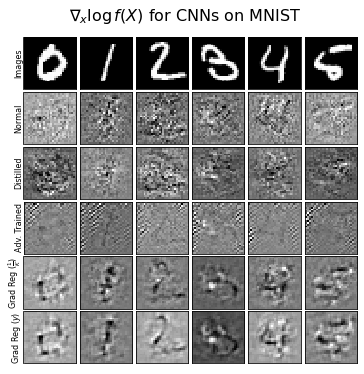

In [ ]:
model_names = ['normal','distilled','advtrain','insensitive','doubleback']
models = [eval(m+'_cnn') for m in model_names]

# show gradients for different digits
show = [np.argwhere(dataset.yt==i)[0,0] for i in range(len(models)+1)]

plot_grads(dataset, models, model_names, show=show)
plt.gcf().suptitle(r'$\nabla_x \log\, f(X)$ for CNNs on MNIST', fontsize=16, y=0.95)
plt.show()

Here dark pixels signify pixels that, if darkened further, would make our model less certain (or more certain if brightened). For the gradient-regularized models, this generally makes sense -- further brightening the digit would increase our certainty.

Light-colored pixels would make us less certain if brightened -- this is most intuitive when you look at the 3s, which really don't want to see their bottom or top loops closed (which would make them resemble 8s).

Personally, I find the gradient-regularized model gradients most intuitively related to the examples (since the normal/distilled ones are super noisy, and the adversarially trained ones have lots of strange background artifacts), but that's definitely a matter of opinion. Regardless of which you think is best, though, there are clearly qualitative differences, and they mean something.

## Compare prediction certainty

One side-effect of regularizing gradients of log probabilities is that it changes the degree of certainty of the model. Let's explore this briefly:

In [ ]:

logps = {}
for m in model_names:
  logps[m] = eval(m+'_cnn_score').logps

ImportError: ignored

KeyError: ignored

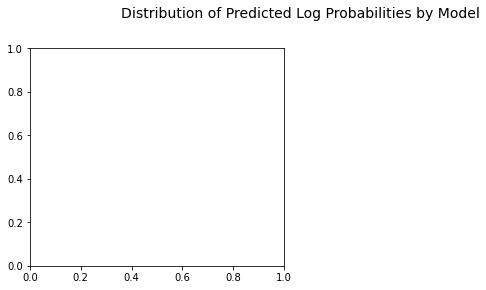

In [ ]:
bins = np.linspace(-50, 0, 50)
plt.figure(figsize=(10,4)).suptitle('Distribution of Predicted Log Probabilities by Model', fontsize=14, y=1.025)
plt.subplot(121)
for m in model_names:
  if m != 'distilled':
    plt.hist(logps[m].flatten(), alpha=0.5, bins=bins, label=model_labels[m], color=model_colors[m])
plt.legend(loc='best')
plt.ylabel('Frequency', fontsize=12)
plt.xticks([-50,-40,-30,-20,-10,0])
plt.subplot(122)
plt.hist(logps['distilled'].flatten(), alpha=0.5, bins=40, label='Distilled', color='skyblue')
plt.legend(loc='upper left')
plt.xticks([-800,-600,-400,-200,0])
plt.figtext(0.5, 0.01, 'Predicted Log Probability', va='top', ha='center', fontsize=12)
plt.show()

Gradient-regularized models assign higher log probabilities to the non-predicted classes, meaning the spread of probabilities is more even between different classes. Distilled models (evaluated at $T=1$, even though they're trained with more even spreads) are actually crazy-certain about their predictions.

Is it better or worse to be intensely certain about your predictions? I also don't have a good answer to this.

What about the size of each model's input gradients?

## Compare Input Gradient L2 Norms

In [ ]:
y1 = onehot((dataset.yt+1)%10, 10)

fgsm_grads = [
  net.batch_input_gradients(Xt, yt) for net in models]

tgsm_grads = [
  net.batch_input_gradients(Xt, y1) for net in models]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



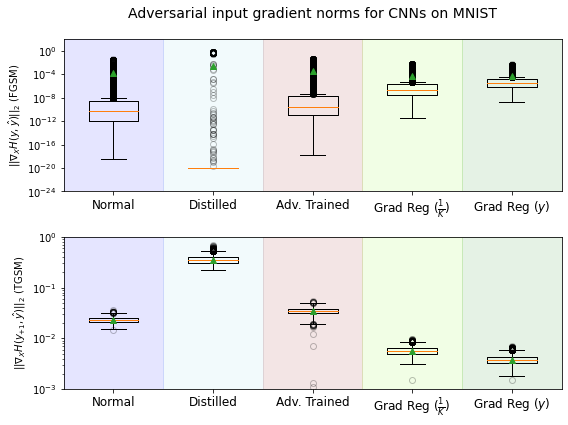

In [ ]:
plt.figure(figsize=(8,6))
    
plt.subplot(211)
grad_size_boxplot(fgsm_grads, model_names)
plt.ylim(1e-24, 1e2)
plt.ylabel(r'$||\nabla_X H(y, \hat{y})||_2$ (FGSM)')

plt.title('Adversarial input gradient norms for CNNs on MNIST', fontsize=14, y=1.1)
    
plt.subplot(212)
grad_size_boxplot(tgsm_grads, model_names)
plt.ylim(1e-3, 1e0)
plt.ylabel(r"$||\nabla_X H(y_{+1}, \hat{y})||_2$ (TGSM)")

plt.tight_layout()
plt.show()

Note the log scales. The takeaway from this plot is that normal, distilled, and adversarially trained models have pretty small but highly variable input gradients of their true-label log probabilities (top), while they have very large input gradients on non-predicted label log probabilities (bottom). Gradient regularized models have input gradient norms which are more similar in order of magnitude between predicted and non-predicted log probabilities. There's also less variance.

This is probably related to the log probability plot above; recall that $\nabla_x \log p(x) = \frac{1}{p(x)} \nabla_x\,  p(x)$. Miniscule non-predicted probabilities should lead to gigantic non-predicted log probability gradients.

Since input gradients are what we use to generate adversarial examples, we should be wary when they explode or behave strangely.

## Generate FGSM examples

Now let's generate some examples using the FGSM, which is defined like

$$
X_{\text{FGSM}} = X + \epsilon\, \text{sign}\left(\nabla_x \sum_k y_k \log f(X)_k \right)
$$

In other words, we're using the true-label log probability gradients to modify our examples such that we increase the information distance between our predictions and labels. Let's generate some examples:

In [ ]:
limit = 256 # so this notebook runs quickly
fgsms = lazydict(lambda m:
          lazydict(lambda eps:
            np.clip(Xt + eps * np.sign(fgsm_grads[model_names.index(m)]),
                    Xt.min(),
                    Xt.max())[:limit]))

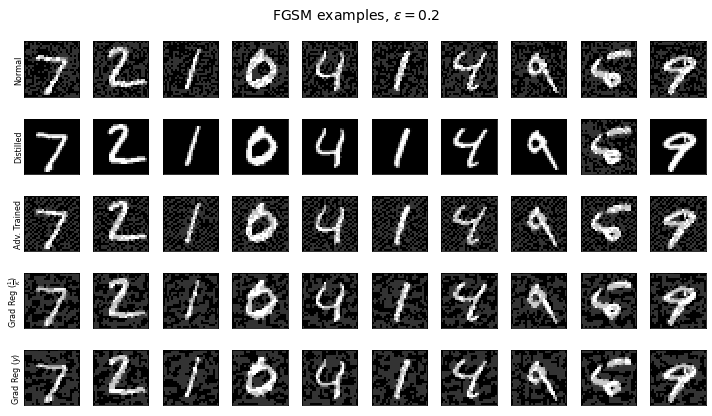

In [ ]:
with figure_grid(len(models),10,rowheight=1.1, rowwidth=10) as g:
  g.title('FGSM examples, $\epsilon=0.2$')
  for m in model_names:
    for i in range(10):
      g.next()
      if i == 0: sidetext(model_labels[m])
      dataset.imshow_example(fgsms[m][0.2][i])

Ooh, interesting. These examples actually look pretty different across methods. Normal CNNs have fairly noisy and unstructured adversarial perturbations, while distilled CNNs have perturbations that in most cases are exactly 0! The one place they aren't is on the weird-looking 5, where the model most likely made a misprediction. The reason for this is that distilled CNNs have vanishing input gradients on the predicted log probability, so we'll only get a true adversarial example when the model makes a mistake!

Adversarially trained CNNs have somewhat strange perturbations -- they display a very regular patterning in the background that looks like a grid. Gradient regularized model perturbations have kind of clumpy sections that appear to show structure at different lengthscales than the other models.

Let's look at accuracy:

## Compare accuracy for every model vs. every other model's FGSM examples

In [ ]:
fgsm_scores = {}
epses = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for model1 in model_names:
  cnn = eval(model1+'_cnn')
  with tf.Session() as sess:
    cnn.init(sess)
    for model2 in model_names:
      print('\n###################################################\n')
      print('Testing {} CNN against {} CNN FGSM examples'.format(model1, model2))
      fgsm_scores[(model1, model2)] = adversarial_grid(sess, cnn, fgsms[model2], yt[:limit], epses=epses)


###################################################

Testing normal CNN against normal CNN FGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.7265625
ε=0.2 has accuracy 0.27734375
ε=0.3 has accuracy 0.11328125
ε=0.4 has accuracy 0.0703125
ε=0.5 has accuracy 0.04296875
ε=0.6 has accuracy 0.0390625
ε=0.7 has accuracy 0.0390625

###################################################

Testing normal CNN against distilled CNN FGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.98828125
ε=0.2 has accuracy 0.98828125
ε=0.3 has accuracy 0.98828125
ε=0.4 has accuracy 0.98828125
ε=0.5 has accuracy 0.98828125
ε=0.6 has accuracy 0.98828125
ε=0.7 has accuracy 0.98828125

###################################################

Testing normal CNN against advtrain CNN FGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.96875
ε=0.2 has accuracy 0.890625
ε=0.3 has accuracy 0.69921875
ε=0.4 has accuracy 0.34765625
ε=0.5 has accuracy 0.16015625
ε=0.6 has accuracy 0.0703125
ε=0

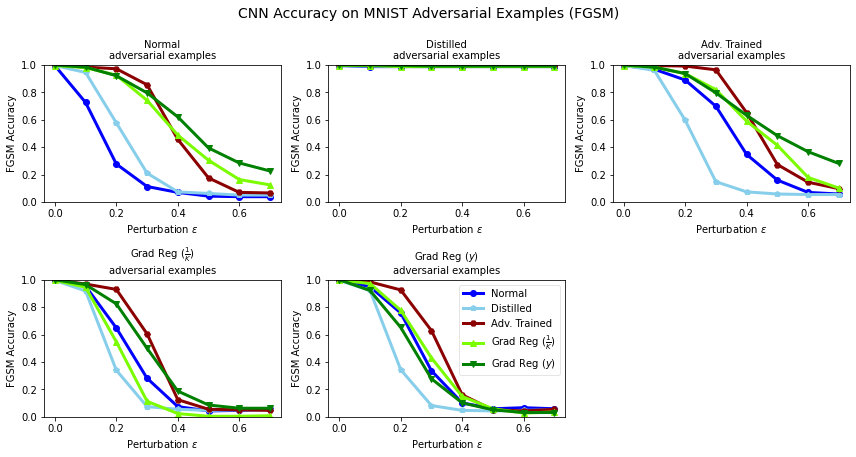

In [ ]:
with figure_grid(2,3) as g:
  g.title('CNN Accuracy on MNIST Adversarial Examples (FGSM)')
  for model2 in model_names:
    g.next()
    plt.title('{}\nadversarial examples'.format(model_labels[model2]), fontsize=10)
    for model1 in model_names:
      model_scores = [fgsm_scores[(model1, model2)][1][eps] for eps in epses]
      plt.plot(epses, model_scores, lw=3,
               label=model_labels[model1],
               marker=model_markers[model1],
               color=model_colors[model1])
    plt.ylim(0,1)
    plt.ylabel('FGSM Accuracy')
    plt.xlabel('Perturbation $\epsilon$')
    if model2 == model_names[-1]:
      plt.legend(loc='best', fontsize=10, framealpha=0.5)

Ok, so what's going on here?

Before anything, just to explain, we're evaluating each model's accuracy against FGSM examples generated to fool every other model. So we're testing for resistance to both white-box and black-box attacks.

Now, looking at the top row, adversarially trained models seem to outperform gradient regularization at $\epsilon \leq 0.3$, which is the same $\epsilon$ at which we trained them to resist the FGSM. However, gradient regularization doesn't do that much worse, and in fact it surpasses them at $\epsilon > 0.3$. Note that 0.3 is a pretty huge perturbation, so it's surprising that we do so well. Also, gradient-regularized model accuracy tends to fall more gradually, at least on the normal and advtrain examples, rather than in a sudden drop. Double backpropagation tends to do better than certainty-insensitivity, too. 

FGSM attacks against distilled models, as we saw above, don't fool any of the models, because the actual adversarial examples are unchanged from their originals! But defensively distilled models tend to do _worst_ on basically all of the other models' examples (except normal models on examples generated specifically to fool them). To me, this suggests that defensive distillation actually makes us _more_ vulnerable to adversarial attacks.

On the bottom row, we see that examples generated to fool gradient-regularized models tend to be pretty effective at fooling all models, even adversarially trained ones.

One question we might want to ask is whether these models failing on the same adversarial examples. For example, if two models are both 50% accurate, are they both failing on the same or opposite 50%s? Let's check briefly:

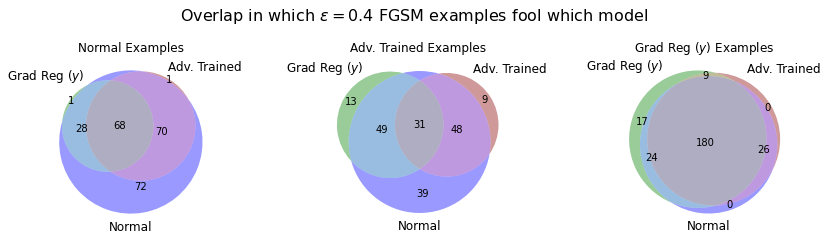

In [ ]:
compare_misclassification_overlaps(fgsm_scores, yt, ['normal','advtrain','doubleback'])
plt.gcf().suptitle('Overlap in which $\epsilon=0.4$ FGSM examples fool which model', y=1.1, fontsize=16)
plt.tight_layout()
plt.show()

Ok, so on examples generated to fool normal models, there are very few examples that fool gradient-regularized or adversarially trained models but not normal models. Between gradient-regularized and adv. trained models, there's a fair amount of overlap, but not complete overlap.

On examples generated to fool adversarially trained models, there's a lot less overlap between all three models' mistakes. This suggests that ensembling their predictions could be very effective as a defense. Personally, I think this difference is because adversarially trained models have such different (and weird) input gradients compared to the other models.

On examples generated to fool gradient-regularized models, unfortunately all of the models misclassify the same examples. To me this suggests that gradient-regularized models' decision boundaries are probably similar to other models' but just smoother -- so motion along the decision surface of a gradient regularized model will remain coherent in the context of any model. What I imagine happening during training is that the models all start out learning similar things at large input lengthscales, but normal models end up learning extra things at small input lengthscales, which makes their decision boundaries less interpretable and makes them more susceptible to uninterpretable adversarial perturbations. Part of the reason I think this is because training accuracy on adversarial examples actually ends up rising and then falling for normal examples:

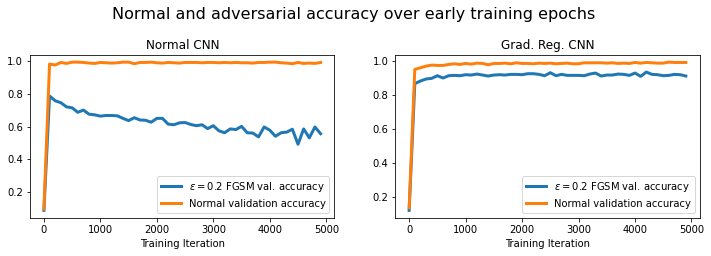

In [ ]:
with open(model_dir + '/mnist-normal-train-curves.pkl', 'rb') as f:
  normal_curves = pickle.load(f)
with open(model_dir + '/mnist-doubleback-56234.13251903491-train-curves.pkl', 'rb') as f:
  double_curves = pickle.load(f)
  
def plot_curves(curves):
  plt.plot(curves['batch_number'][:pts], curves['adv_accuracy'][:pts], lw=3, label='$\epsilon=0.2$ FGSM val. accuracy')
  plt.plot(curves['batch_number'][:pts], curves['test_accuracy'][:pts], lw=3, label='Normal validation accuracy')
  plt.xlabel('Training Iteration')
  plt.legend(loc='lower right')
  
pts = 50
plt.figure(figsize=(12,3)).suptitle('Normal and adversarial accuracy over early training epochs', fontsize=16, y=1.1)
plt.subplot(121)
plt.title('Normal CNN')
plot_curves(normal_curves)
plt.subplot(122)
plt.title('Grad. Reg. CNN')
plot_curves(double_curves)
plt.show()

These results suggest we could probably defend against some adversarial examples just by ensembling with extremely undertrained models!

Let's look at the TGSM now:

## Generate TGSM examples

In [ ]:
tgsms = lazydict(lambda m:
          lazydict(lambda eps:
            np.clip(Xt - eps * np.sign(tgsm_grads[model_names.index(m)]),
                    Xt.min(),
                    Xt.max())[:limit]))

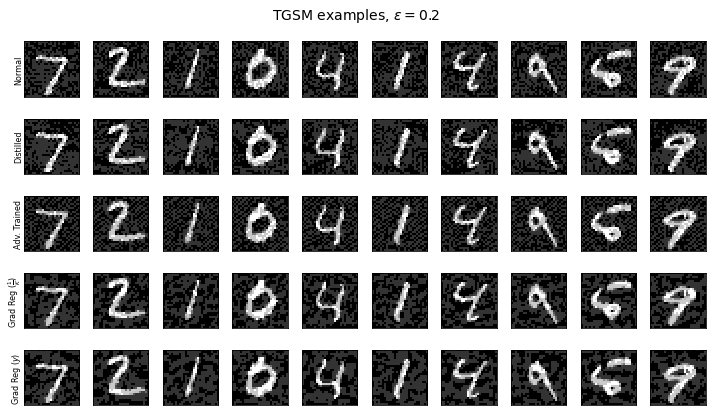

In [ ]:
with figure_grid(len(models),10,rowheight=1.1, rowwidth=10) as g:
  g.title('TGSM examples, $\epsilon=0.2$')
  for model in model_names:
    for i in range(10):
      g.next()
      if i == 0: sidetext(model_labels[model])
      dataset.imshow_example(tgsms[model][0.2][i])

In general, TGSM perturbations seem to have similar characteristics to FGSM perturbations, except for distilled models, we stop getting gradient underflow :)

Note that in this case, I'm using the label + 1 (modulo 10) as the target.

## Compare accuracy for every model vs. every other model's TGSM examples

In [ ]:
tgsm_scores = {}
for model1 in model_names:
  cnn = eval(model1+'_cnn')
  with tf.Session() as sess:
    cnn.init(sess)
    for model2 in model_names:
      print('\n###################################################\n')
      print('Testing {} CNN against {} CNN TGSM examples'.format(model1, model2))
      tgsm_scores[(model1, model2)] = adversarial_grid(sess, cnn, tgsms[model2], yt[:limit], epses=epses)


###################################################

Testing normal CNN against normal CNN TGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.80859375
ε=0.2 has accuracy 0.25
ε=0.3 has accuracy 0.07421875
ε=0.4 has accuracy 0.015625
ε=0.5 has accuracy 0.03125
ε=0.6 has accuracy 0.0546875
ε=0.7 has accuracy 0.0546875

###################################################

Testing normal CNN against distilled CNN TGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.96875
ε=0.2 has accuracy 0.7421875
ε=0.3 has accuracy 0.3828125
ε=0.4 has accuracy 0.1484375
ε=0.5 has accuracy 0.078125
ε=0.6 has accuracy 0.0625
ε=0.7 has accuracy 0.05859375

###################################################

Testing normal CNN against advtrain CNN TGSM examples
ε=0 has accuracy 0.99609375
ε=0.1 has accuracy 0.96875
ε=0.2 has accuracy 0.90234375
ε=0.3 has accuracy 0.62890625
ε=0.4 has accuracy 0.296875
ε=0.5 has accuracy 0.11328125
ε=0.6 has accuracy 0.0625
ε=0.7 has accuracy 0.054687

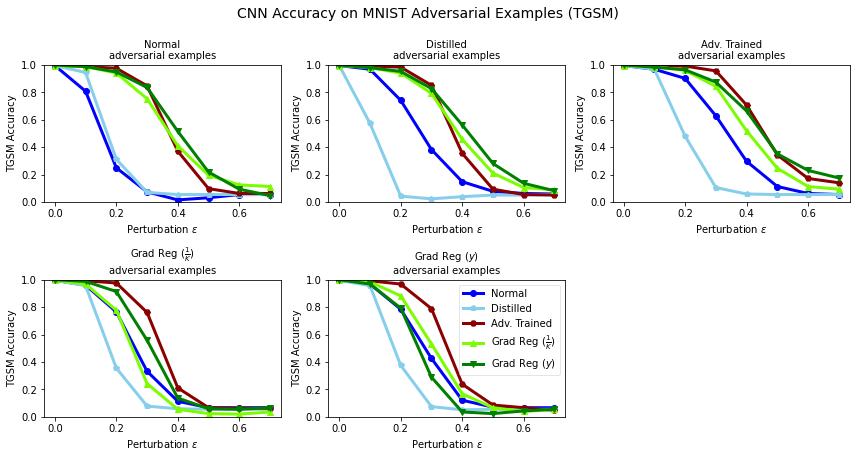

In [ ]:
with figure_grid(2,3) as g:
  g.title('CNN Accuracy on MNIST Adversarial Examples (TGSM)')
  for model2 in model_names:
    g.next()
    plt.title('{}\nadversarial examples'.format(model_labels[model2]), fontsize=10)
    for model1 in model_names:
      model_scores = [tgsm_scores[(model1, model2)][1][eps] for eps in epses]
      plt.plot(epses, model_scores, lw=3,
               label=model_labels[model1],
               marker=model_markers[model1],
               color=model_colors[model1])
    plt.ylim(0,1)
    plt.ylabel('TGSM Accuracy')
    plt.xlabel('Perturbation $\epsilon$')
    if model2 == model_names[-1]:
      plt.legend(loc='best', fontsize=10, framealpha=0.5)

Accuracy results are largely similar as for FGSM, except distilled models perform very poorly on _all_ examples now.

Let's look at misclassification overlap:

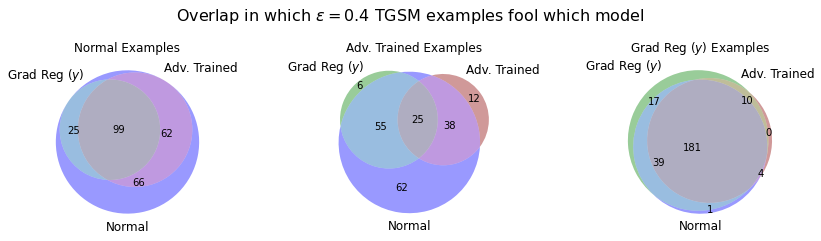

In [ ]:
compare_misclassification_overlaps(tgsm_scores, yt, ['normal','advtrain','doubleback'], eps=0.4)
plt.gcf().suptitle('Overlap in which $\epsilon=0.4$ TGSM examples fool which model', y=1.1, fontsize=16)
plt.tight_layout()
plt.show()

Similar results as before -- gradient regularized TGSM examples fool everyone, but there's less overlap on other examples.

## Iterated TGSM Confusion Matrices

Let's finally consider what happens when we repeatedly run the TGSM at $\epsilon=0.1$. Since we let ourselves take multiple steps, we can move nonlinearly through input space. In this case, we don't necessarily want to ask about accuracy, since you'd expect that after enough steps, the adversarial examples we generate actually _should_ resemble their targets. Let's see whether that happens:

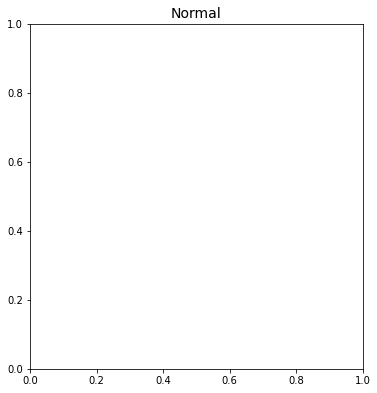

FileNotFoundError: ignored

In [ ]:
import matplotlib.image as mpimg
with figure_grid(2,3,rowwidth=15,rowheight=5.25) as g:
  for m in model_names:
    g.next()
    plt.title(model_labels[m], fontsize=14)
    img = mpimg.imread('../cached/tgsm/mnist/{}/tgsm-targetgrid-eps0pt1-epoch10.png'.format(m))
    plt.imshow(img)
    plt.axis('off')

We've only taken 10 steps (just enough to fully whiten or darken a patch, since $\epsilon=0.1$ and the range of values is $1$), but we can already see pretty major differences between the models' examples. To me at least, normal and especially distilled TGSM examples seem much noisier but effectively unchanged. Some of the adversarially trained examples look more like their targets, but it mostly seems like noise.

TGSM examples for gradient-regularized models, on the other hand, look way more like their targets than their original models. Some of them are a teensy-bit monstrous (especially the mutant 4s), but that actually may shed light on what the model has learned. It's also interesting to see different variants of digits which emerge -- e.g. sometimes, we see 7s with lines through the middle, but sometimes not, and some of the 1s have lines at the bottom while others don't.

Another way to think about this form of the TGSM is that we're basically doing gradient descent in input space (except we take the elementwise sign on the gradient vector). What these results show is that _trajectories_ through input space are more realistic for gradient-regularized models. Since input gradients are the normals to the model's decision surface, we can take this to mean that gradient-regularized model decision surfaces have more interpretable curvature. This ends up increasing both their adversarial robustness and interpretability!

You can view some animations of the process here:
- [Normal CNN MNIST TGSM animations](https://drive.google.com/file/d/1wgeZkvtOcOztwpN6HxaqiJgGp-YZ_WXn/view)
- [Distilled MNIST TGSM animations](https://drive.google.com/file/d/1O-B2sn8X3v6l8e2ai4eBYd28M3ZYSKpf/view)
- [Adv. trained MNIST TGSM animations](https://drive.google.com/file/d/1AO95xhwrY4KP9n_buC6ncK4xUjwdcLJ9/view)
- [Dbl. Backprop MNIST TGSM animations](https://drive.google.com/file/d/1naIFTZ7VkLmfx5D9J3lhDAsXd5WjQD8T/view)
- [Insensitive MNIST TGSM Animations](https://drive.google.com/file/d/1W3x0_YCInyC49dCzzzDIYw0IeZJEXqLL/view)

Interestingly, the gradient-regularized models quickly converge a fixed point (with a few background pixels switching back and forth between two values -- if we weren't taking the sign, this would probably dissipate). Distilled models step forward until the predicted class flips, then stop changing altogether (because then the TGSM turns into the FGSM, and gradients underflow).

You can view these animations for [other models](https://drive.google.com/drive/u/1/folders/1myc_2Jp3rszrcBNWfUKqS-aGKWHFq2pg) too.